<a href="https://colab.research.google.com/github/wadaxy/artificial-intelligence-with-python-ja/blob/master/notebooks/ch10_dl_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10章 チューニング技法

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [5]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))

# 結果確認
print(n_output)

10


## 10.4 過学習とその対応

### ドロップアウト関数の動作確認

In [7]:
# ドロップアウトテスト用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [8]:
# dropout関数の定義
dropout = nn.Dropout(0.5)

# 訓練フェーズでの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測フェーズでの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


## 10.5 共通関数のライブラリ化

In [9]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 112 (delta 0), reused 2 (delta 0), pack-reused 108 (from 1)
Receiving objects: 100% (112/112), 21.12 MiB | 51.48 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Common Library for PyTorch
Author: M. Akaishi


## データ準備

In [10]:
# Transformsの定義

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [11]:
# データ取得用関数 Dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


In [12]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set,
    batch_size = batch_size, shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,
    batch_size = batch_size, shuffle = False)

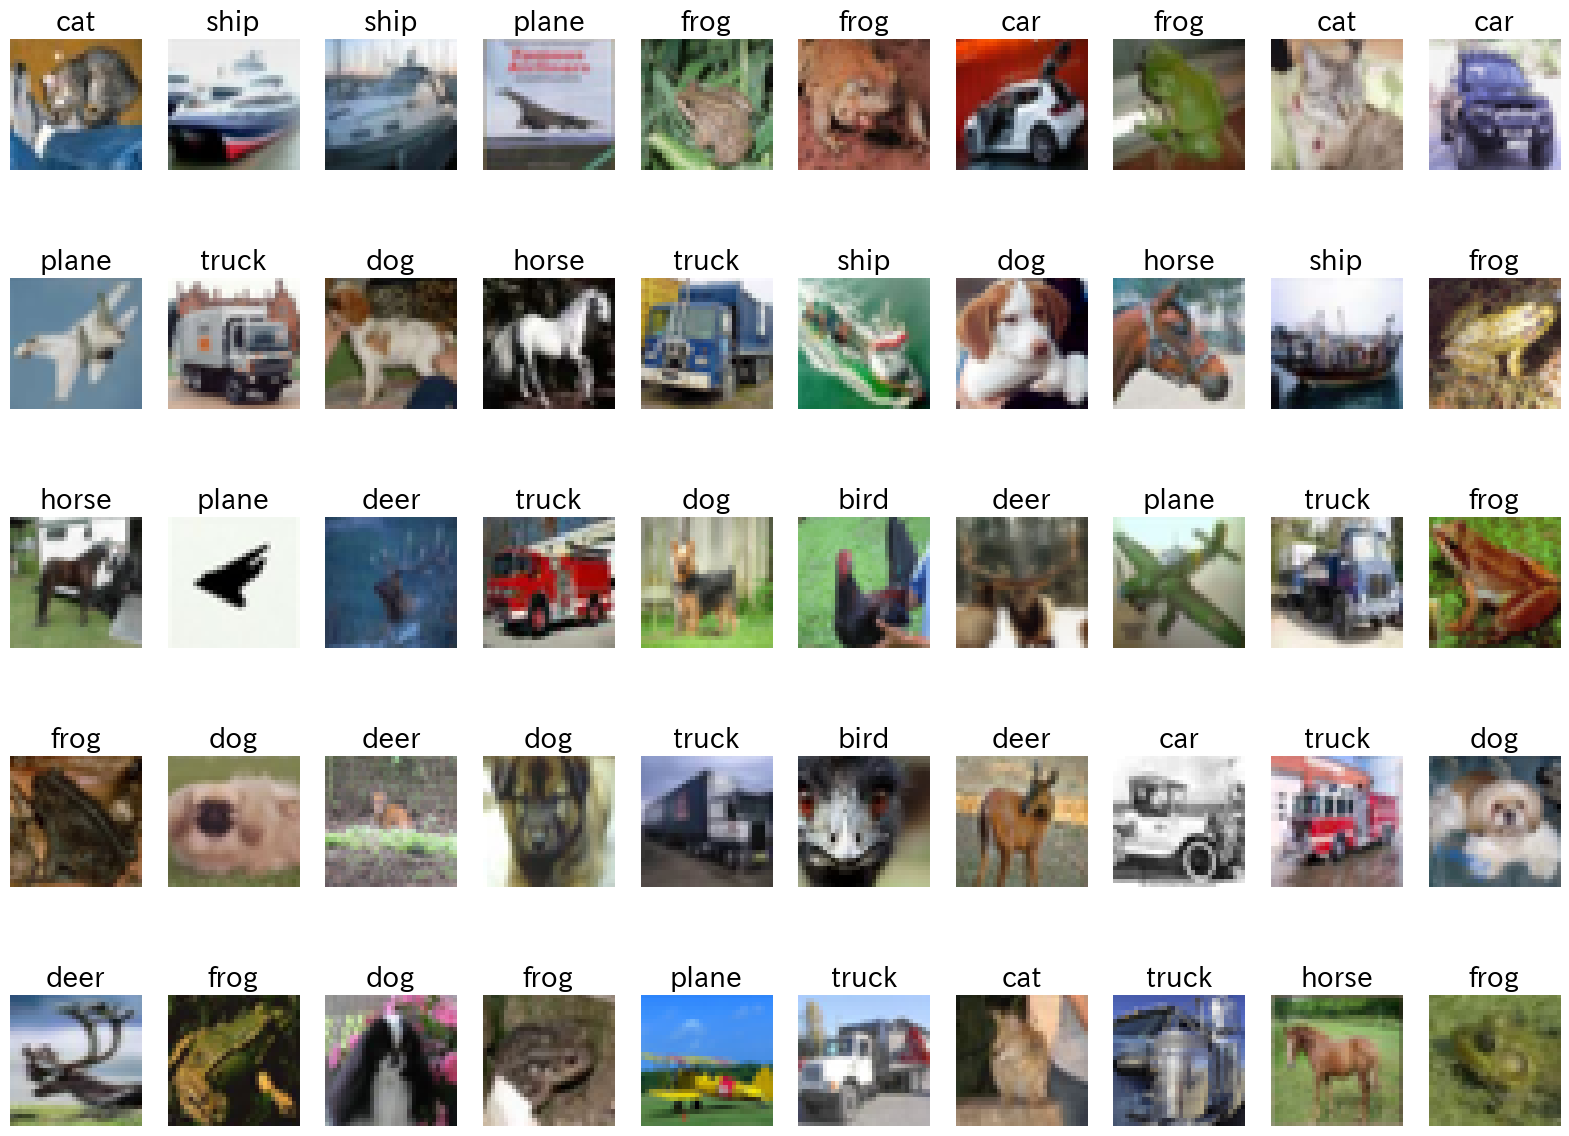

In [13]:
# 最初の50個の表示
show_images_labels(test_loader, classes, None, None)

## 10.6 階層を深くしたモデルの実装

In [14]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

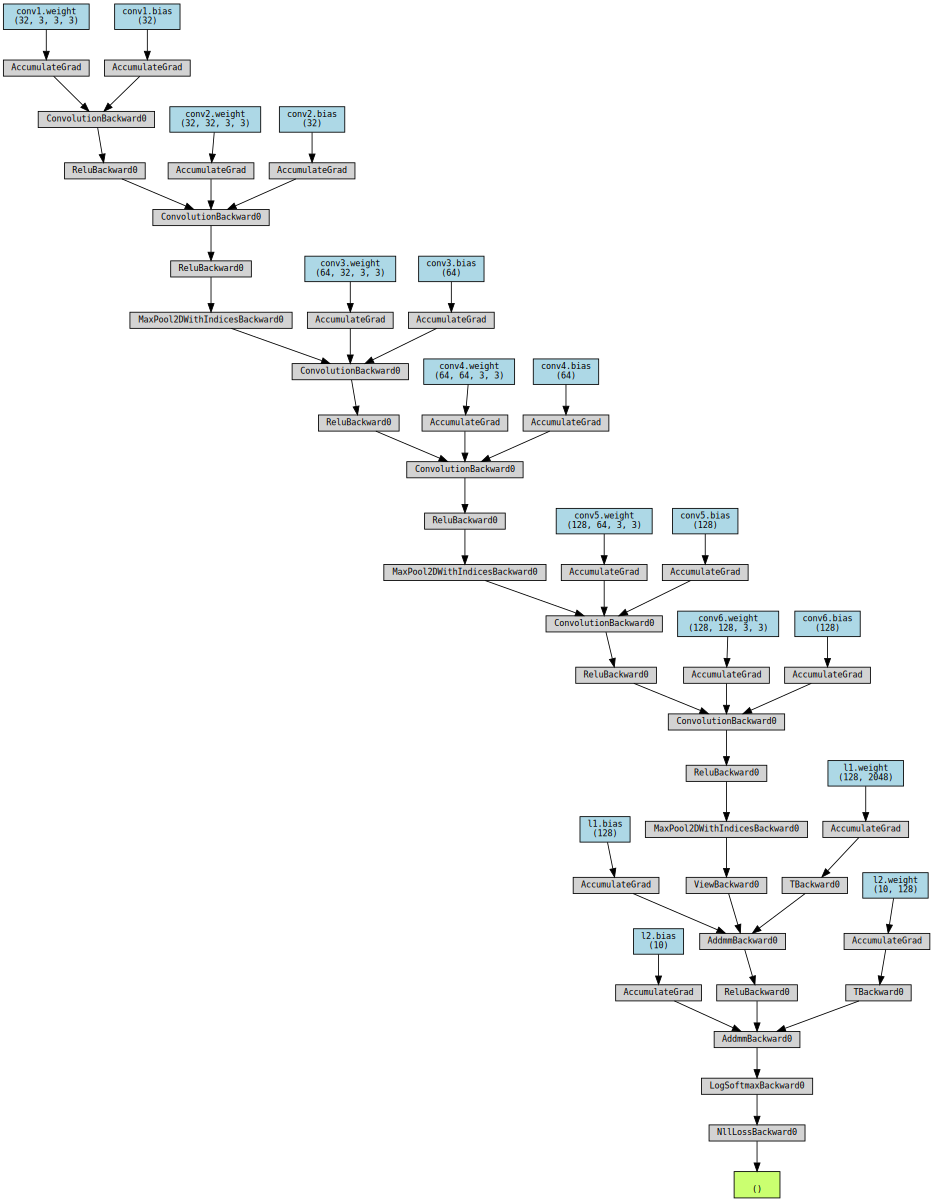

In [15]:
# 損失関数のグラフ表示
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [16]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [17]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.30313 acc: 0.10000 val_loss: 2.30278, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 2.30268 acc: 0.10000 val_loss: 2.30252, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 2.30248 acc: 0.10000 val_loss: 2.30234, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 2.30228 acc: 0.10842 val_loss: 2.30210, val_acc: 0.10170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 2.30196 acc: 0.13026 val_loss: 2.30164, val_acc: 0.17460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 2.30118 acc: 0.16746 val_loss: 2.30032, val_acc: 0.19090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 2.29810 acc: 0.18536 val_loss: 2.29356, val_acc: 0.21840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 2.24540 acc: 0.21884 val_loss: 2.09686, val_acc: 0.23860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 2.01624 acc: 0.26152 val_loss: 1.94558, val_acc: 0.29340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.90672 acc: 0.31276 val_loss: 1.89068, val_acc: 0.31430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.79656 acc: 0.35134 val_loss: 1.69886, val_acc: 0.38670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.69691 acc: 0.38422 val_loss: 1.62537, val_acc: 0.41410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.62864 acc: 0.40634 val_loss: 1.56040, val_acc: 0.42870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.57425 acc: 0.42162 val_loss: 1.61362, val_acc: 0.41770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.53020 acc: 0.43782 val_loss: 1.51132, val_acc: 0.44100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.48212 acc: 0.45892 val_loss: 1.44078, val_acc: 0.47230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.44176 acc: 0.47328 val_loss: 1.40145, val_acc: 0.48600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.39943 acc: 0.49358 val_loss: 1.41924, val_acc: 0.48750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.35556 acc: 0.51322 val_loss: 1.34394, val_acc: 0.51200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.31155 acc: 0.53244 val_loss: 1.29489, val_acc: 0.53320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.26001 acc: 0.54886 val_loss: 1.23360, val_acc: 0.55380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.21883 acc: 0.56632 val_loss: 1.20795, val_acc: 0.56660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.17573 acc: 0.58132 val_loss: 1.20480, val_acc: 0.57050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.14329 acc: 0.59390 val_loss: 1.15718, val_acc: 0.58640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.09936 acc: 0.61028 val_loss: 1.12050, val_acc: 0.59660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.06270 acc: 0.62464 val_loss: 1.09682, val_acc: 0.61150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.02350 acc: 0.64048 val_loss: 1.10724, val_acc: 0.60870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.98678 acc: 0.65190 val_loss: 1.05177, val_acc: 0.63410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.95604 acc: 0.66656 val_loss: 1.00347, val_acc: 0.64890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.91866 acc: 0.68016 val_loss: 0.97602, val_acc: 0.65600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.88686 acc: 0.68872 val_loss: 0.97588, val_acc: 0.65950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.85805 acc: 0.69868 val_loss: 0.94849, val_acc: 0.66890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.82451 acc: 0.71334 val_loss: 0.98657, val_acc: 0.65870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.79565 acc: 0.72344 val_loss: 0.91935, val_acc: 0.68030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.76231 acc: 0.73620 val_loss: 0.93928, val_acc: 0.67430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.73433 acc: 0.74322 val_loss: 0.92939, val_acc: 0.67910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.70671 acc: 0.75332 val_loss: 0.93924, val_acc: 0.68690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.67560 acc: 0.76416 val_loss: 0.92273, val_acc: 0.68910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.64294 acc: 0.77690 val_loss: 0.93043, val_acc: 0.69350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.61724 acc: 0.78578 val_loss: 0.92686, val_acc: 0.69530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.58868 acc: 0.79472 val_loss: 0.94999, val_acc: 0.68780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.55971 acc: 0.80366 val_loss: 0.93363, val_acc: 0.70240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.52966 acc: 0.81412 val_loss: 0.91916, val_acc: 0.70460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.49826 acc: 0.82586 val_loss: 0.94641, val_acc: 0.70290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.47318 acc: 0.83450 val_loss: 1.01964, val_acc: 0.68780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43904 acc: 0.84554 val_loss: 1.04723, val_acc: 0.69070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.40876 acc: 0.85482 val_loss: 1.02135, val_acc: 0.69160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.37922 acc: 0.86824 val_loss: 1.04833, val_acc: 0.69790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.34814 acc: 0.87920 val_loss: 1.06133, val_acc: 0.70270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.31757 acc: 0.88910 val_loss: 1.10077, val_acc: 0.69860


初期状態: 損失: 2.30278 精度: 0.10000
最終状態: 損失: 1.10077 精度: 0.69860


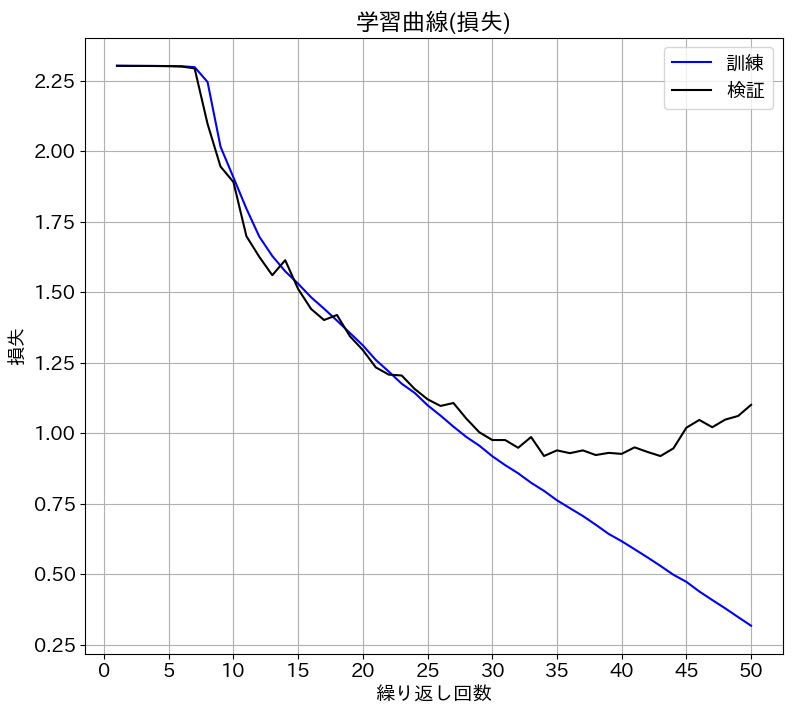

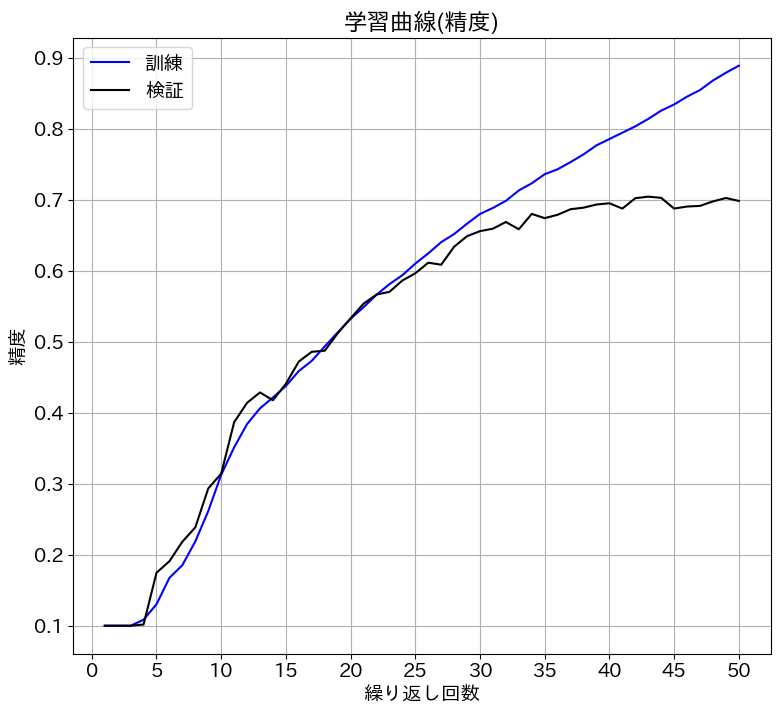

In [18]:
evaluate_history(history)

## 10.7 最適化関数の選択

### momentumの設定

In [19]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にmomentumを指定
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

In [20]:
# 学習

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 2.28585 acc: 0.12124 val_loss: 2.05091, val_acc: 0.24080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 1.80039 acc: 0.33642 val_loss: 1.52378, val_acc: 0.42710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 1.41268 acc: 0.48200 val_loss: 1.26529, val_acc: 0.54390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 1.16007 acc: 0.58314 val_loss: 1.09248, val_acc: 0.61290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.96830 acc: 0.65812 val_loss: 0.88739, val_acc: 0.68770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.81496 acc: 0.71094 val_loss: 0.82621, val_acc: 0.71040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.68569 acc: 0.76058 val_loss: 0.76470, val_acc: 0.73660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.58269 acc: 0.79706 val_loss: 0.72593, val_acc: 0.75350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.49088 acc: 0.82626 val_loss: 0.70852, val_acc: 0.76350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.42125 acc: 0.85188 val_loss: 0.78508, val_acc: 0.75440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.33994 acc: 0.87918 val_loss: 0.75618, val_acc: 0.76870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.28294 acc: 0.89888 val_loss: 0.78846, val_acc: 0.76930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.23472 acc: 0.91628 val_loss: 0.89458, val_acc: 0.74930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.18977 acc: 0.93238 val_loss: 0.99616, val_acc: 0.75730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.15851 acc: 0.94376 val_loss: 0.98753, val_acc: 0.76600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.13377 acc: 0.95216 val_loss: 1.13223, val_acc: 0.75400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.12750 acc: 0.95392 val_loss: 1.08406, val_acc: 0.76470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.10380 acc: 0.96336 val_loss: 1.18845, val_acc: 0.76610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.09630 acc: 0.96612 val_loss: 1.38971, val_acc: 0.75650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.08773 acc: 0.96932 val_loss: 1.27097, val_acc: 0.76330


初期状態: 損失: 2.05091 精度: 0.24080
最終状態: 損失: 1.27097 精度: 0.76330


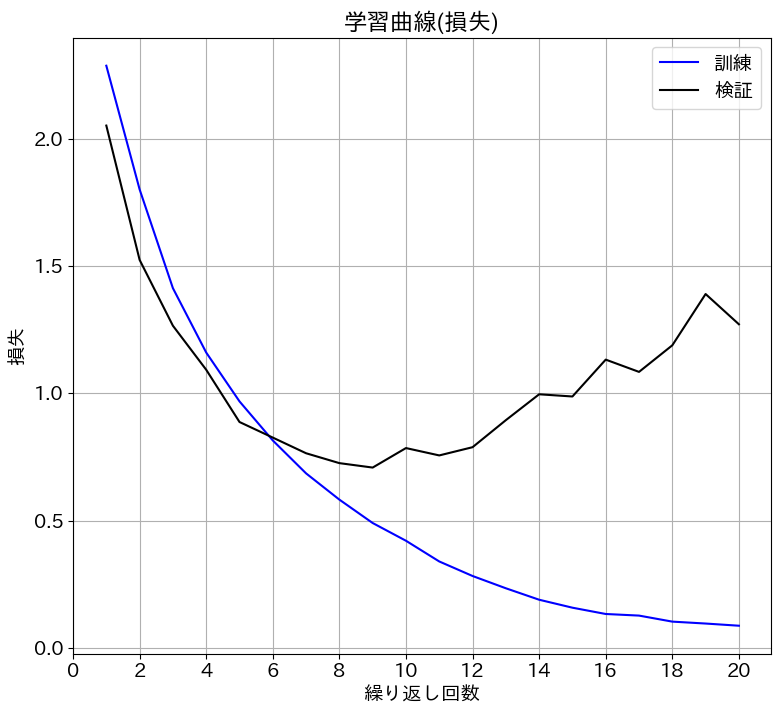

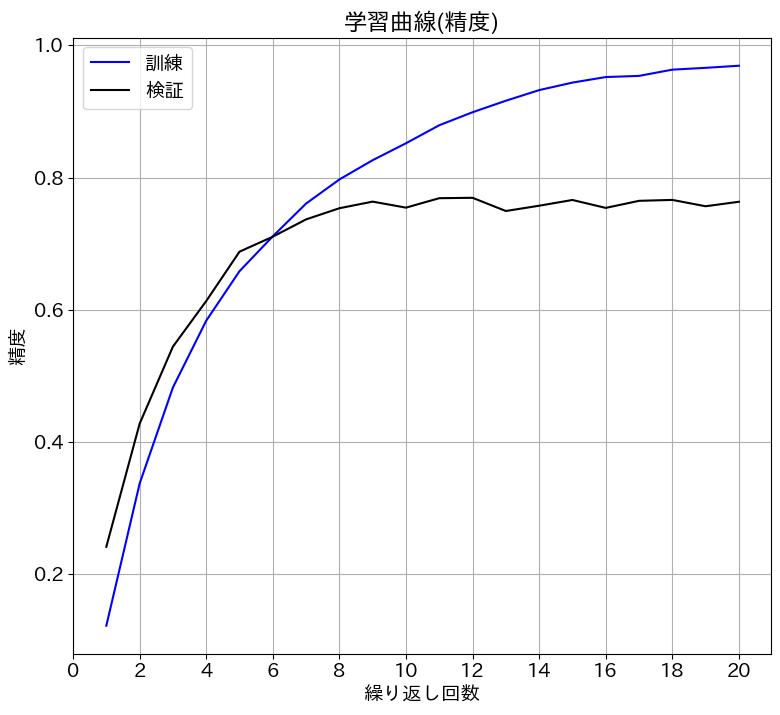

In [21]:
evaluate_history(history2)

### Adamの利用

In [22]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にAdamを指定
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [23]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [24]:
# 学習

num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 1.59945 acc: 0.41138 val_loss: 1.25068, val_acc: 0.54530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 1.09955 acc: 0.60582 val_loss: 1.01700, val_acc: 0.63780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.88552 acc: 0.68580 val_loss: 0.89557, val_acc: 0.68720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.73824 acc: 0.73916 val_loss: 0.79515, val_acc: 0.72130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.62088 acc: 0.78130 val_loss: 0.71484, val_acc: 0.75080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.53376 acc: 0.81154 val_loss: 0.71159, val_acc: 0.75570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.45115 acc: 0.84036 val_loss: 0.71385, val_acc: 0.76190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.37493 acc: 0.86806 val_loss: 0.73536, val_acc: 0.76740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.30760 acc: 0.89048 val_loss: 0.79240, val_acc: 0.76050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.24981 acc: 0.91074 val_loss: 0.86756, val_acc: 0.76510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.20147 acc: 0.92756 val_loss: 0.99365, val_acc: 0.76490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.16882 acc: 0.94052 val_loss: 1.07233, val_acc: 0.75970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.14627 acc: 0.94828 val_loss: 1.09873, val_acc: 0.75710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.12913 acc: 0.95406 val_loss: 1.23569, val_acc: 0.75800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.12329 acc: 0.95614 val_loss: 1.21263, val_acc: 0.75500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.10538 acc: 0.96330 val_loss: 1.29622, val_acc: 0.75240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.09802 acc: 0.96622 val_loss: 1.31555, val_acc: 0.74750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.09751 acc: 0.96628 val_loss: 1.43836, val_acc: 0.74470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.09325 acc: 0.96794 val_loss: 1.48037, val_acc: 0.75860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.07671 acc: 0.97378 val_loss: 1.43286, val_acc: 0.75310


初期状態: 損失: 1.25068 精度: 0.54530
最終状態: 損失: 1.43286 精度: 0.75310


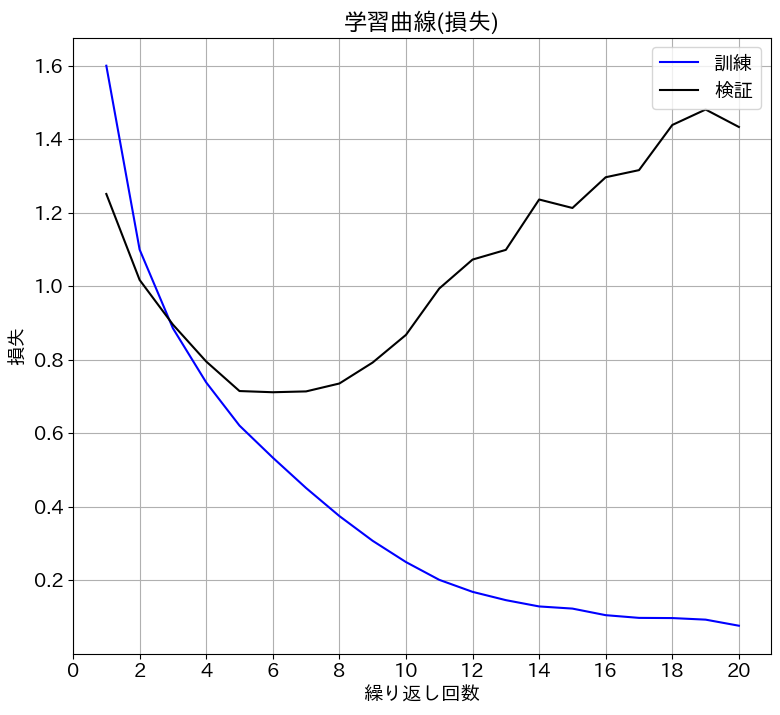

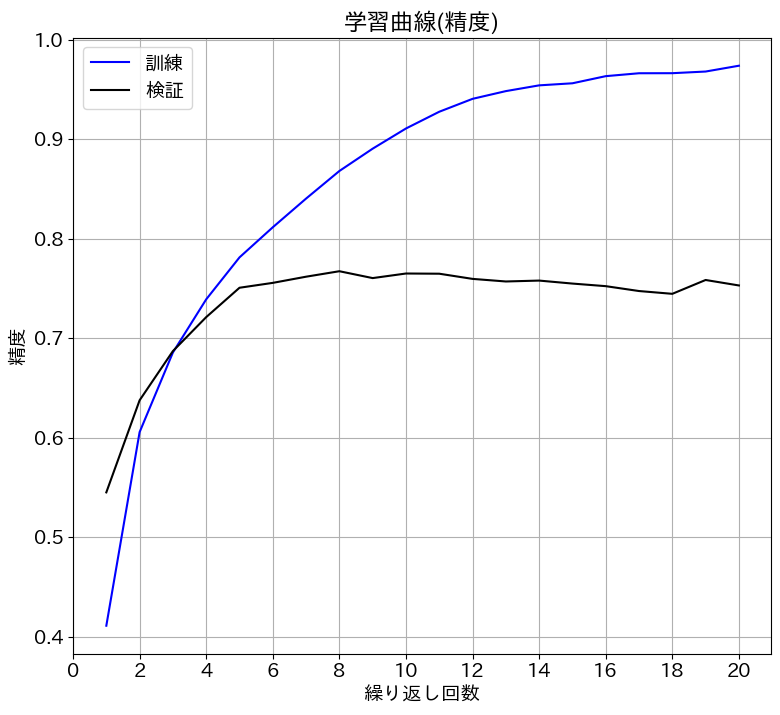

In [25]:
evaluate_history(history3)

### 結果比較

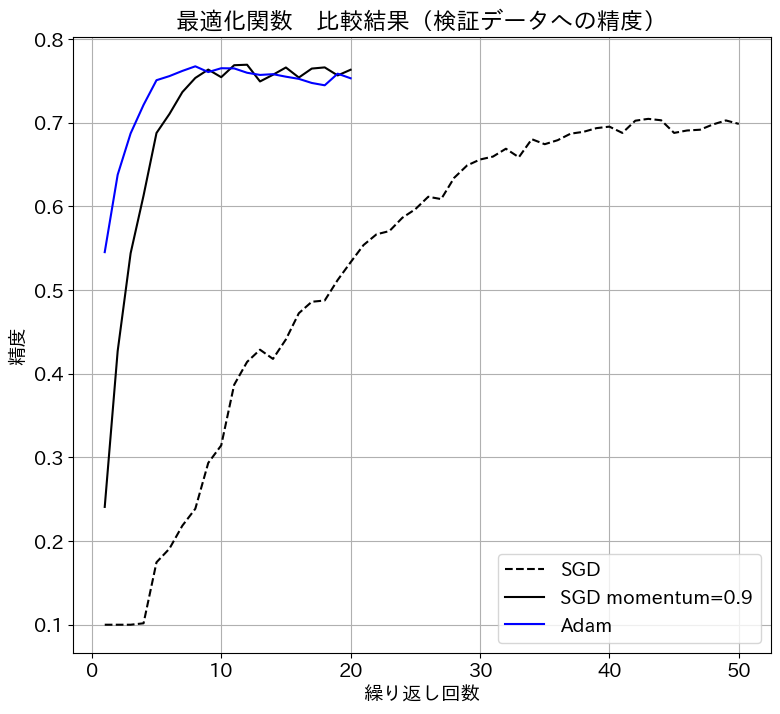

In [26]:
# 結果の比較(検証データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,4], label='SGD', c='k',ls='dashed' )
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9', c='k')
plt.plot(history3[:,0], history3[:,4], label='Adam', c='b')
plt.title('最適化関数　比較結果（検証データへの精度）')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.legend()
plt.show()

## 10.8 ドロップアウト

In [27]:
# 予測クラスの定義

class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

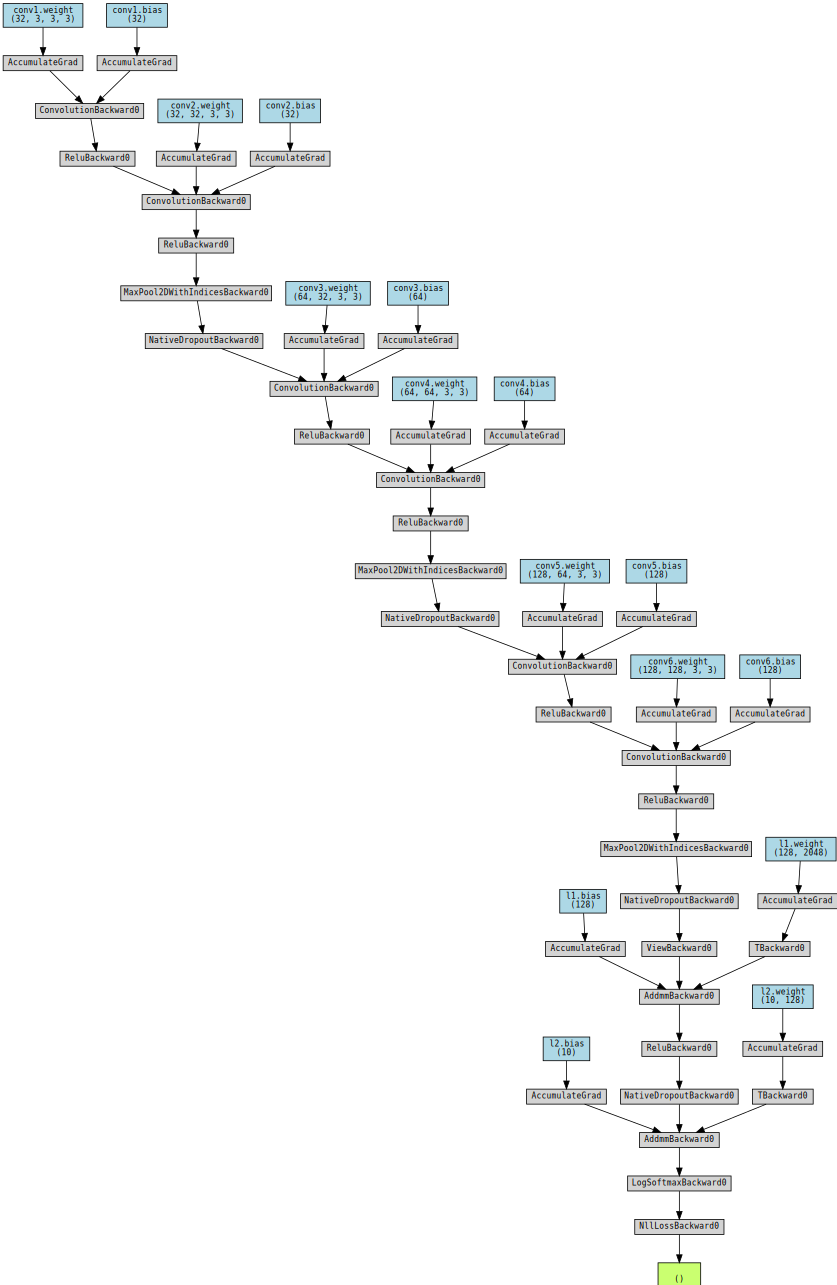

In [28]:
# 損失関数のグラフ表示
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [29]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [30]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.70620 acc: 0.36640 val_loss: 1.29072, val_acc: 0.52560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.27402 acc: 0.53650 val_loss: 1.04578, val_acc: 0.62190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.10828 acc: 0.60248 val_loss: 0.98585, val_acc: 0.64780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.99111 acc: 0.64668 val_loss: 0.85818, val_acc: 0.69520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.90819 acc: 0.68170 val_loss: 0.77856, val_acc: 0.72800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.84071 acc: 0.70578 val_loss: 0.74809, val_acc: 0.73610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.79389 acc: 0.72386 val_loss: 0.71553, val_acc: 0.75060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.75287 acc: 0.73912 val_loss: 0.69761, val_acc: 0.75490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.71540 acc: 0.75206 val_loss: 0.63706, val_acc: 0.78290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.68389 acc: 0.76330 val_loss: 0.68392, val_acc: 0.76890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.66231 acc: 0.77024 val_loss: 0.65662, val_acc: 0.77470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.64300 acc: 0.77688 val_loss: 0.62946, val_acc: 0.78820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.62391 acc: 0.78442 val_loss: 0.59392, val_acc: 0.79780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.59685 acc: 0.79274 val_loss: 0.57862, val_acc: 0.80790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.58331 acc: 0.79728 val_loss: 0.60077, val_acc: 0.80180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.57183 acc: 0.80336 val_loss: 0.57412, val_acc: 0.80800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.55120 acc: 0.80806 val_loss: 0.59214, val_acc: 0.79930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.54526 acc: 0.81150 val_loss: 0.60517, val_acc: 0.80170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.53114 acc: 0.81578 val_loss: 0.55395, val_acc: 0.81620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.52610 acc: 0.81584 val_loss: 0.56459, val_acc: 0.81670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51084 acc: 0.82310 val_loss: 0.56892, val_acc: 0.81300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50720 acc: 0.82492 val_loss: 0.57224, val_acc: 0.81480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49832 acc: 0.82546 val_loss: 0.53986, val_acc: 0.82600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49772 acc: 0.82744 val_loss: 0.54764, val_acc: 0.81800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48189 acc: 0.83118 val_loss: 0.56956, val_acc: 0.81530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.47598 acc: 0.83398 val_loss: 0.54904, val_acc: 0.81970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.47249 acc: 0.83668 val_loss: 0.53801, val_acc: 0.82570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47395 acc: 0.83604 val_loss: 0.55086, val_acc: 0.81810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.45816 acc: 0.84072 val_loss: 0.55976, val_acc: 0.82160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.45917 acc: 0.83894 val_loss: 0.52434, val_acc: 0.82900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.45069 acc: 0.84376 val_loss: 0.52431, val_acc: 0.83260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.44762 acc: 0.84620 val_loss: 0.54000, val_acc: 0.82550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.44023 acc: 0.84592 val_loss: 0.53814, val_acc: 0.82730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.43269 acc: 0.84826 val_loss: 0.52389, val_acc: 0.83040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.44035 acc: 0.84622 val_loss: 0.53320, val_acc: 0.83070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.43319 acc: 0.84856 val_loss: 0.53021, val_acc: 0.83090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.42758 acc: 0.85002 val_loss: 0.55114, val_acc: 0.82670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.42149 acc: 0.85340 val_loss: 0.53601, val_acc: 0.83010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.41886 acc: 0.85436 val_loss: 0.55381, val_acc: 0.82750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.41978 acc: 0.85218 val_loss: 0.55074, val_acc: 0.83090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.41360 acc: 0.85538 val_loss: 0.55400, val_acc: 0.82690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.41022 acc: 0.85678 val_loss: 0.53268, val_acc: 0.83280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.40934 acc: 0.85778 val_loss: 0.54531, val_acc: 0.82690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.40327 acc: 0.85872 val_loss: 0.55199, val_acc: 0.82860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.39813 acc: 0.86124 val_loss: 0.55375, val_acc: 0.82280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.40046 acc: 0.86014 val_loss: 0.53297, val_acc: 0.82940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.39899 acc: 0.86098 val_loss: 0.53618, val_acc: 0.83470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.39536 acc: 0.86294 val_loss: 0.55522, val_acc: 0.83180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.39340 acc: 0.86204 val_loss: 0.53487, val_acc: 0.83450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.39048 acc: 0.86488 val_loss: 0.53137, val_acc: 0.83480


初期状態: 損失: 1.29072 精度: 0.52560
最終状態: 損失: 0.53137 精度: 0.83480


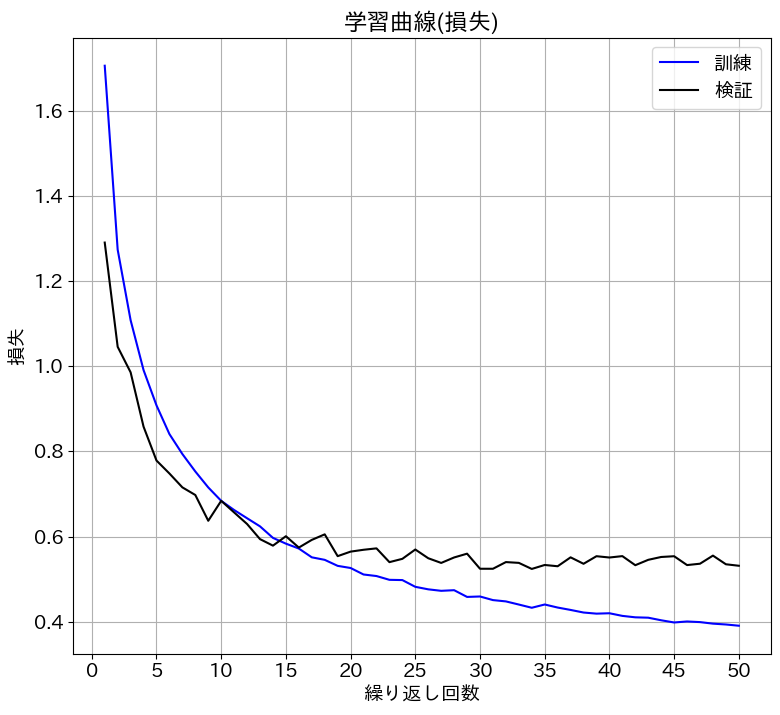

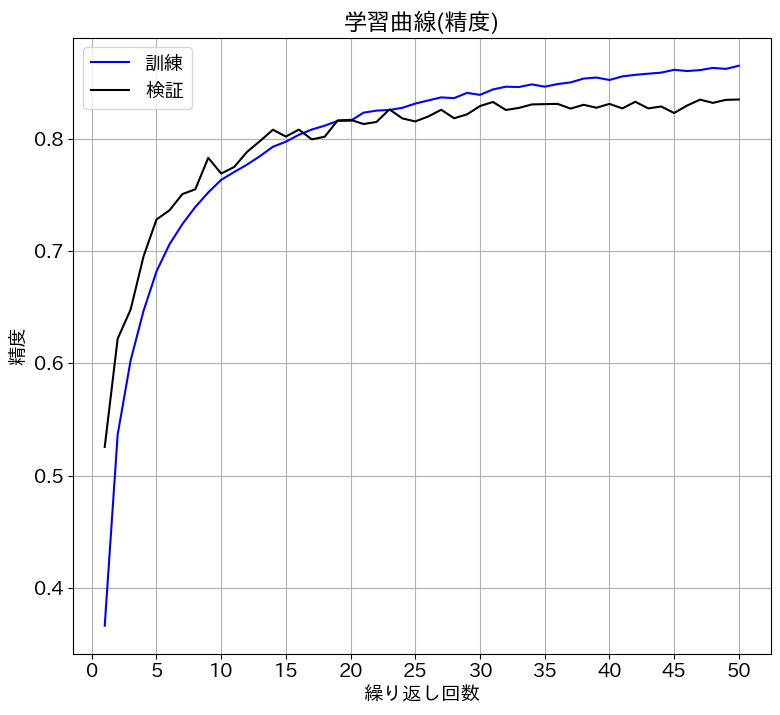

In [31]:
evaluate_history(history)

## 10.9 Batch Normalization

In [32]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [33]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [34]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.51948 acc: 0.43698 val_loss: 1.20316, val_acc: 0.56190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.14703 acc: 0.58900 val_loss: 1.36932, val_acc: 0.55360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.00364 acc: 0.64716 val_loss: 0.81415, val_acc: 0.71420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.90108 acc: 0.68574 val_loss: 0.72830, val_acc: 0.74390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.83890 acc: 0.71140 val_loss: 0.68400, val_acc: 0.76500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.78585 acc: 0.73144 val_loss: 0.67851, val_acc: 0.76780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.75125 acc: 0.74340 val_loss: 0.63981, val_acc: 0.77660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.70787 acc: 0.75846 val_loss: 0.63293, val_acc: 0.78140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.67332 acc: 0.77240 val_loss: 0.55166, val_acc: 0.81560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.64106 acc: 0.78240 val_loss: 0.57002, val_acc: 0.80730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.61304 acc: 0.79348 val_loss: 0.53942, val_acc: 0.82190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.59194 acc: 0.80038 val_loss: 0.54682, val_acc: 0.82000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.55800 acc: 0.81248 val_loss: 0.49425, val_acc: 0.83560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54447 acc: 0.81728 val_loss: 0.50725, val_acc: 0.82750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52728 acc: 0.82344 val_loss: 0.50646, val_acc: 0.83040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.51268 acc: 0.82644 val_loss: 0.47414, val_acc: 0.84430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.49235 acc: 0.83658 val_loss: 0.47693, val_acc: 0.84320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.47978 acc: 0.83924 val_loss: 0.46346, val_acc: 0.84480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.45638 acc: 0.84796 val_loss: 0.45468, val_acc: 0.84810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.44549 acc: 0.84992 val_loss: 0.46829, val_acc: 0.85010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.43508 acc: 0.85366 val_loss: 0.45916, val_acc: 0.84970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.42690 acc: 0.85634 val_loss: 0.47411, val_acc: 0.84650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.41781 acc: 0.85966 val_loss: 0.46085, val_acc: 0.84860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.39870 acc: 0.86774 val_loss: 0.45433, val_acc: 0.85310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.38835 acc: 0.86902 val_loss: 0.44580, val_acc: 0.85720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.38375 acc: 0.86968 val_loss: 0.42558, val_acc: 0.86090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.37073 acc: 0.87408 val_loss: 0.45409, val_acc: 0.85770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.35820 acc: 0.87874 val_loss: 0.48635, val_acc: 0.84960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.35412 acc: 0.88034 val_loss: 0.43699, val_acc: 0.85900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.35076 acc: 0.88176 val_loss: 0.44816, val_acc: 0.86120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.34080 acc: 0.88616 val_loss: 0.43557, val_acc: 0.86600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.33593 acc: 0.88588 val_loss: 0.48072, val_acc: 0.85170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.33023 acc: 0.88880 val_loss: 0.45618, val_acc: 0.85850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.32446 acc: 0.88924 val_loss: 0.46160, val_acc: 0.85860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.31813 acc: 0.89118 val_loss: 0.43875, val_acc: 0.86610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.30923 acc: 0.89616 val_loss: 0.45144, val_acc: 0.86410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.30709 acc: 0.89576 val_loss: 0.44820, val_acc: 0.86510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.30329 acc: 0.89792 val_loss: 0.45376, val_acc: 0.86330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.30076 acc: 0.89818 val_loss: 0.43414, val_acc: 0.87060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.29363 acc: 0.89930 val_loss: 0.42471, val_acc: 0.86690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.28339 acc: 0.90360 val_loss: 0.43125, val_acc: 0.86900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.28556 acc: 0.90282 val_loss: 0.43674, val_acc: 0.86900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.27738 acc: 0.90570 val_loss: 0.42511, val_acc: 0.86920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.27786 acc: 0.90326 val_loss: 0.42668, val_acc: 0.86840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.27120 acc: 0.90748 val_loss: 0.42836, val_acc: 0.87200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.26517 acc: 0.90900 val_loss: 0.43975, val_acc: 0.86740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.25667 acc: 0.91122 val_loss: 0.44007, val_acc: 0.86940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.25774 acc: 0.91202 val_loss: 0.43452, val_acc: 0.87320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.25214 acc: 0.91272 val_loss: 0.44687, val_acc: 0.86810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.24625 acc: 0.91468 val_loss: 0.43134, val_acc: 0.87470


初期状態: 損失: 1.20316 精度: 0.56190
最終状態: 損失: 0.43134 精度: 0.87470


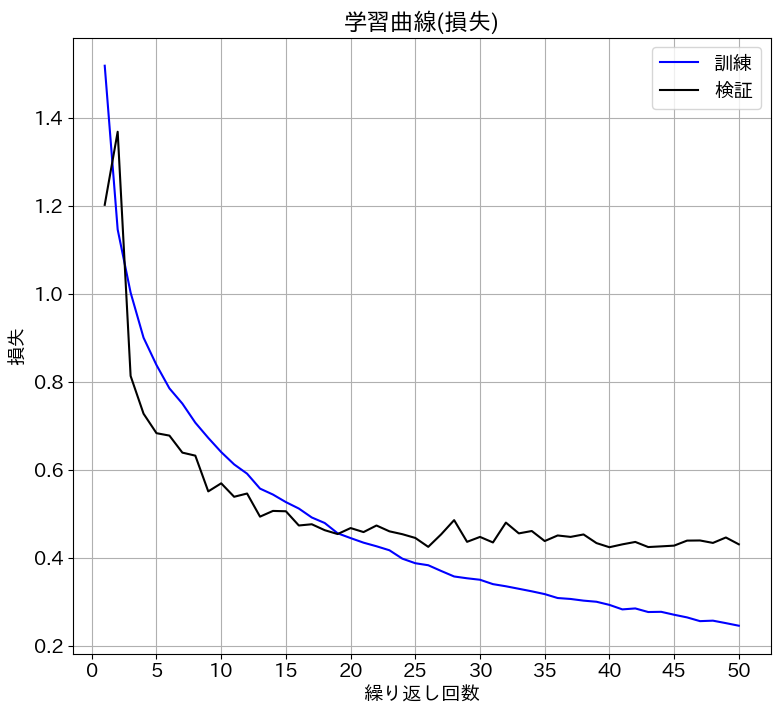

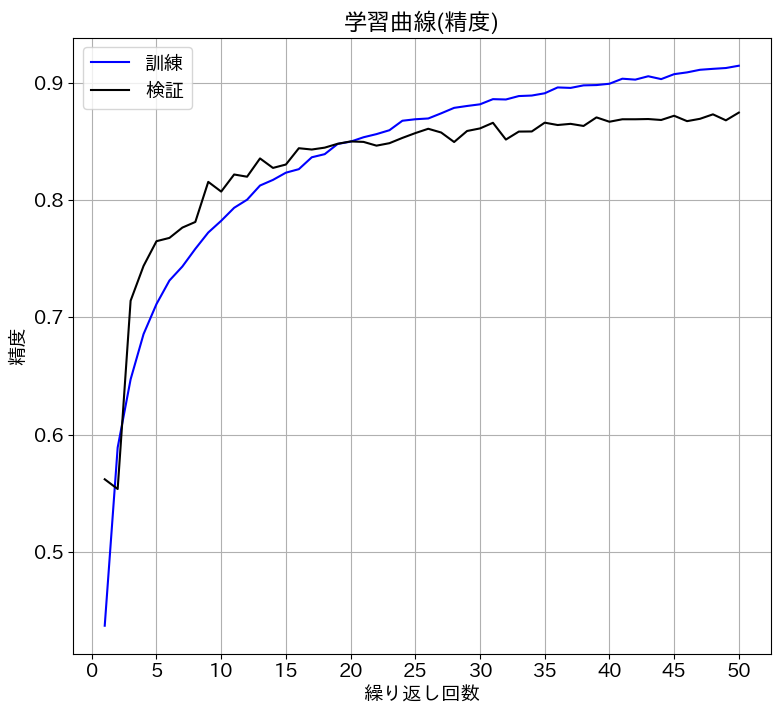

In [35]:
evaluate_history(history)

## 10.10 Data Augmentation

In [36]:
# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [37]:
# transfrom_trainを利用したデータセットの定義
train_set2 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# traisform_trainを利用したデータローダーの定義
batch_size = 100
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

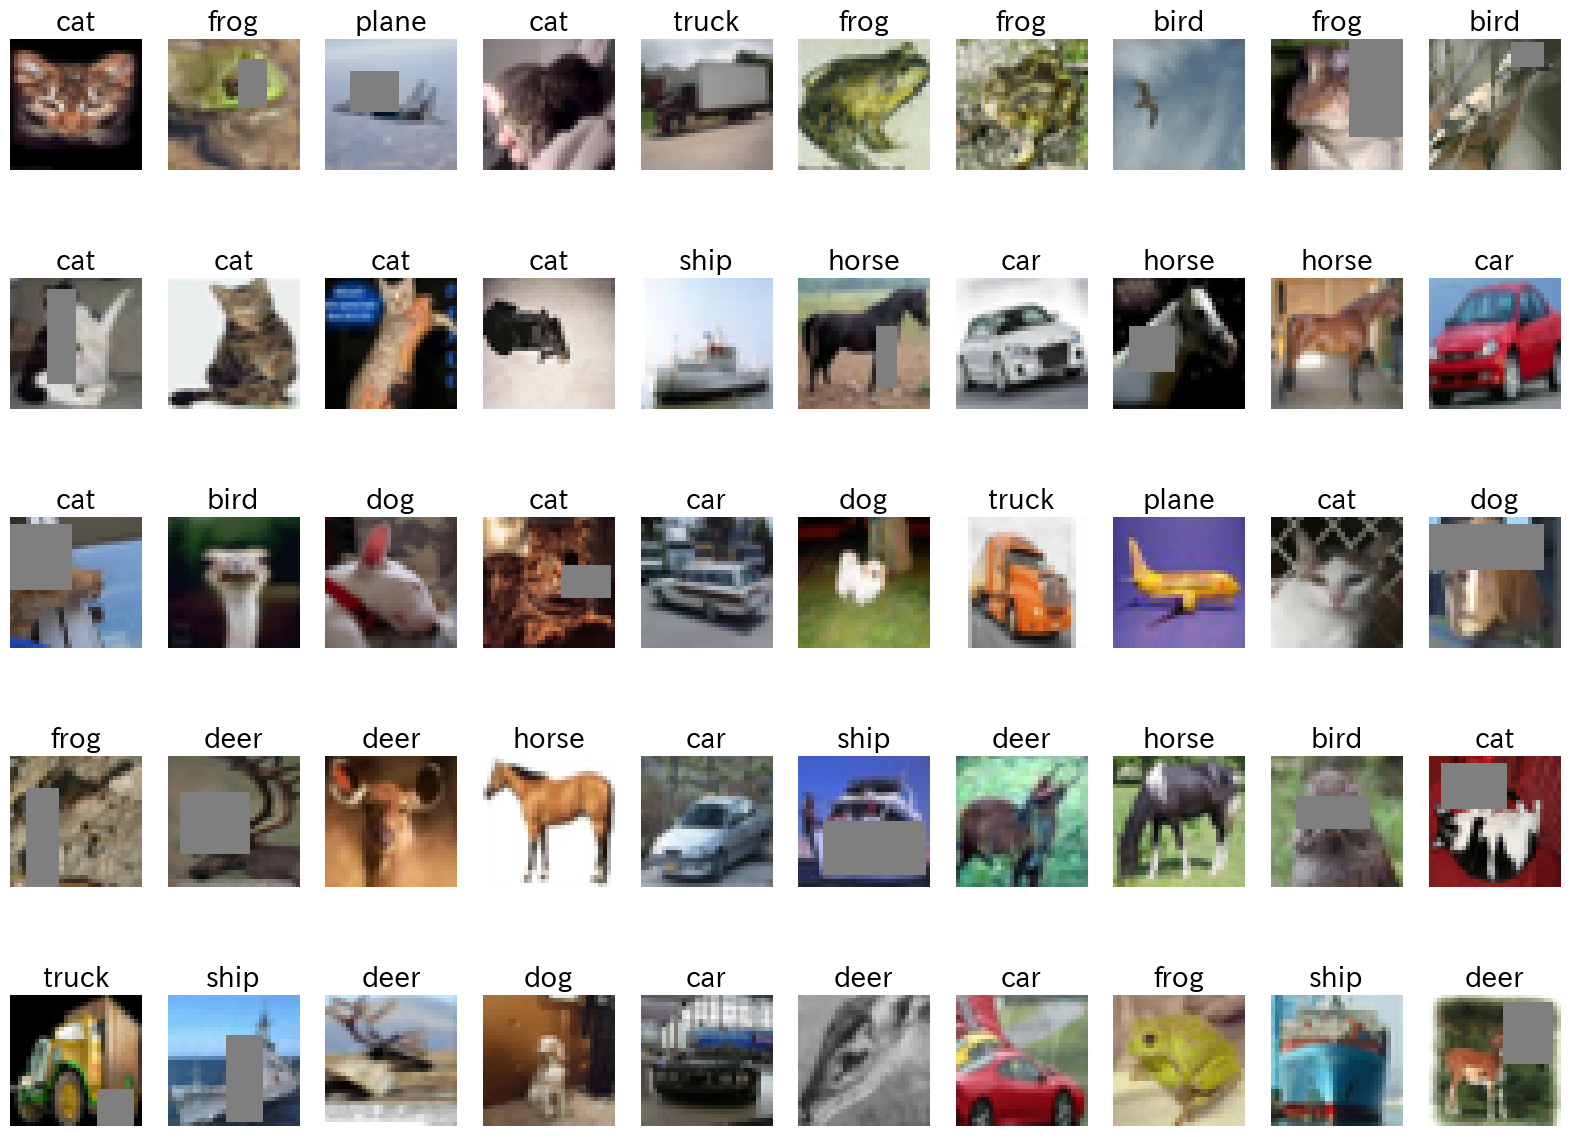

In [38]:
# 新しい訓練用データの先頭50個を表示してみる

# 乱数初期化
torch_seed()

show_images_labels(train_loader2, classes, None, None)

In [39]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [40]:
# 学習
# 同じモデルでtrain_loader2に変更

num_epochs = 100
history = fit(net, optimizer, criterion, num_epochs,
        train_loader2, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.60168 acc: 0.40880 val_loss: 1.29300, val_acc: 0.54610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.26360 acc: 0.54606 val_loss: 1.01112, val_acc: 0.62730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/100], loss: 1.12263 acc: 0.60196 val_loss: 0.93103, val_acc: 0.67700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/100], loss: 1.03947 acc: 0.63538 val_loss: 0.93554, val_acc: 0.66970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.98725 acc: 0.65714 val_loss: 0.88081, val_acc: 0.69760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.94442 acc: 0.67172 val_loss: 0.75348, val_acc: 0.73420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.90718 acc: 0.68732 val_loss: 0.71225, val_acc: 0.75230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.88123 acc: 0.69510 val_loss: 0.82159, val_acc: 0.72480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.85152 acc: 0.70670 val_loss: 0.63485, val_acc: 0.77420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.82439 acc: 0.71824 val_loss: 0.60427, val_acc: 0.78990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.80904 acc: 0.72460 val_loss: 0.63491, val_acc: 0.77880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.78470 acc: 0.73476 val_loss: 0.62085, val_acc: 0.79160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.76938 acc: 0.74056 val_loss: 0.55940, val_acc: 0.80930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.75754 acc: 0.74482 val_loss: 0.55217, val_acc: 0.80840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.73207 acc: 0.75426 val_loss: 0.53507, val_acc: 0.81860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.71942 acc: 0.75678 val_loss: 0.54899, val_acc: 0.80870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.70822 acc: 0.76482 val_loss: 0.50354, val_acc: 0.82630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.69799 acc: 0.76626 val_loss: 0.50922, val_acc: 0.82730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.68288 acc: 0.77392 val_loss: 0.48226, val_acc: 0.83730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.66599 acc: 0.77564 val_loss: 0.48811, val_acc: 0.83500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.65930 acc: 0.77990 val_loss: 0.49494, val_acc: 0.82960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.64802 acc: 0.78394 val_loss: 0.47485, val_acc: 0.84610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.63816 acc: 0.78588 val_loss: 0.45889, val_acc: 0.84770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.62592 acc: 0.79266 val_loss: 0.48790, val_acc: 0.83970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.61884 acc: 0.79386 val_loss: 0.49469, val_acc: 0.83310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.60999 acc: 0.79732 val_loss: 0.44197, val_acc: 0.85060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.59494 acc: 0.80002 val_loss: 0.48482, val_acc: 0.84230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.59055 acc: 0.80206 val_loss: 0.48090, val_acc: 0.84120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.58012 acc: 0.80512 val_loss: 0.42174, val_acc: 0.86100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.57892 acc: 0.80840 val_loss: 0.42163, val_acc: 0.86110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.57172 acc: 0.81102 val_loss: 0.42301, val_acc: 0.85870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.56398 acc: 0.81090 val_loss: 0.40270, val_acc: 0.86620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.55822 acc: 0.81462 val_loss: 0.41778, val_acc: 0.86350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.55201 acc: 0.81542 val_loss: 0.42048, val_acc: 0.85970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.54157 acc: 0.81828 val_loss: 0.40559, val_acc: 0.86760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.53433 acc: 0.81960 val_loss: 0.42080, val_acc: 0.86310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.52555 acc: 0.82530 val_loss: 0.40822, val_acc: 0.86770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.52751 acc: 0.82300 val_loss: 0.38814, val_acc: 0.86970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.52038 acc: 0.82700 val_loss: 0.41471, val_acc: 0.86740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.51204 acc: 0.82820 val_loss: 0.39567, val_acc: 0.86820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.51560 acc: 0.82634 val_loss: 0.41360, val_acc: 0.86850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.50629 acc: 0.82816 val_loss: 0.39726, val_acc: 0.87180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.50305 acc: 0.83040 val_loss: 0.38927, val_acc: 0.87060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.49774 acc: 0.83070 val_loss: 0.39578, val_acc: 0.86800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.49636 acc: 0.83320 val_loss: 0.39383, val_acc: 0.86930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.49595 acc: 0.83116 val_loss: 0.38553, val_acc: 0.86930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.48034 acc: 0.84076 val_loss: 0.40564, val_acc: 0.86760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.48579 acc: 0.83618 val_loss: 0.40319, val_acc: 0.87210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.48191 acc: 0.83822 val_loss: 0.38992, val_acc: 0.87180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.47927 acc: 0.83880 val_loss: 0.38626, val_acc: 0.87440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.47075 acc: 0.83974 val_loss: 0.38579, val_acc: 0.87530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.47102 acc: 0.84168 val_loss: 0.39123, val_acc: 0.87310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.47035 acc: 0.84032 val_loss: 0.40340, val_acc: 0.86890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.46427 acc: 0.84254 val_loss: 0.38120, val_acc: 0.87520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.46027 acc: 0.84318 val_loss: 0.37862, val_acc: 0.87800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.46633 acc: 0.84014 val_loss: 0.38168, val_acc: 0.87580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.45770 acc: 0.84534 val_loss: 0.40079, val_acc: 0.86930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.45515 acc: 0.84506 val_loss: 0.39570, val_acc: 0.87320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.45325 acc: 0.84466 val_loss: 0.35786, val_acc: 0.88510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.45066 acc: 0.84764 val_loss: 0.37413, val_acc: 0.87810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.44595 acc: 0.85078 val_loss: 0.37505, val_acc: 0.87550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.44369 acc: 0.84970 val_loss: 0.36787, val_acc: 0.87960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.43750 acc: 0.85040 val_loss: 0.38636, val_acc: 0.87650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.43415 acc: 0.85104 val_loss: 0.38687, val_acc: 0.87680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.43364 acc: 0.85172 val_loss: 0.37632, val_acc: 0.87860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.43597 acc: 0.85242 val_loss: 0.35779, val_acc: 0.88400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.43222 acc: 0.85286 val_loss: 0.36514, val_acc: 0.88290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.43622 acc: 0.85090 val_loss: 0.35208, val_acc: 0.88430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.42568 acc: 0.85490 val_loss: 0.37539, val_acc: 0.87760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.43108 acc: 0.85334 val_loss: 0.36560, val_acc: 0.88260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.41942 acc: 0.85772 val_loss: 0.36882, val_acc: 0.88010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.42579 acc: 0.85508 val_loss: 0.36615, val_acc: 0.88120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.41679 acc: 0.85786 val_loss: 0.37252, val_acc: 0.87820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.41836 acc: 0.85624 val_loss: 0.37166, val_acc: 0.87990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.41378 acc: 0.85946 val_loss: 0.37212, val_acc: 0.88130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.41161 acc: 0.85882 val_loss: 0.35003, val_acc: 0.88800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.41332 acc: 0.85892 val_loss: 0.38753, val_acc: 0.88000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.40622 acc: 0.86232 val_loss: 0.37850, val_acc: 0.87870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.40794 acc: 0.86032 val_loss: 0.38019, val_acc: 0.88220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.40513 acc: 0.86376 val_loss: 0.34963, val_acc: 0.89040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.40871 acc: 0.86098 val_loss: 0.34700, val_acc: 0.89180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.40387 acc: 0.86262 val_loss: 0.35145, val_acc: 0.88690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.40300 acc: 0.86312 val_loss: 0.35289, val_acc: 0.88630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.40129 acc: 0.86448 val_loss: 0.35268, val_acc: 0.88900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.40104 acc: 0.86322 val_loss: 0.36936, val_acc: 0.88280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.39901 acc: 0.86316 val_loss: 0.34870, val_acc: 0.88850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.39960 acc: 0.86346 val_loss: 0.34494, val_acc: 0.88980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.39524 acc: 0.86408 val_loss: 0.35638, val_acc: 0.88660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.39874 acc: 0.86600 val_loss: 0.35335, val_acc: 0.88810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.39218 acc: 0.86588 val_loss: 0.36496, val_acc: 0.88320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.39384 acc: 0.86512 val_loss: 0.34540, val_acc: 0.88630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.38873 acc: 0.86956 val_loss: 0.35737, val_acc: 0.88790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.38973 acc: 0.86526 val_loss: 0.34738, val_acc: 0.88830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.39012 acc: 0.86674 val_loss: 0.34835, val_acc: 0.89040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.38482 acc: 0.86816 val_loss: 0.35406, val_acc: 0.88740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.38488 acc: 0.86810 val_loss: 0.35368, val_acc: 0.89110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.38576 acc: 0.86720 val_loss: 0.35579, val_acc: 0.89010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.38244 acc: 0.86942 val_loss: 0.36023, val_acc: 0.88730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.38134 acc: 0.86852 val_loss: 0.35524, val_acc: 0.88940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.38179 acc: 0.86958 val_loss: 0.35554, val_acc: 0.88850


初期状態: 損失: 1.29300 精度: 0.54610
最終状態: 損失: 0.35554 精度: 0.88850


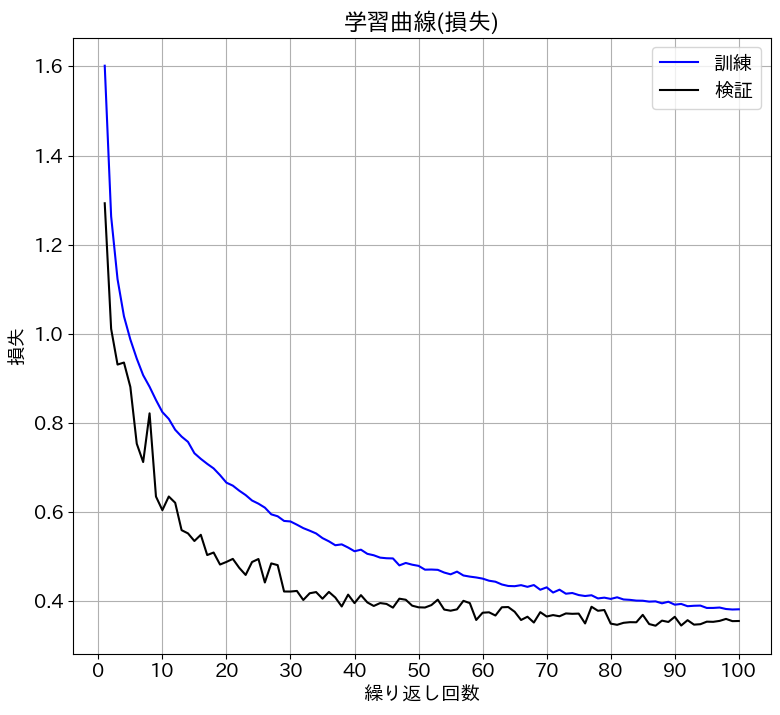

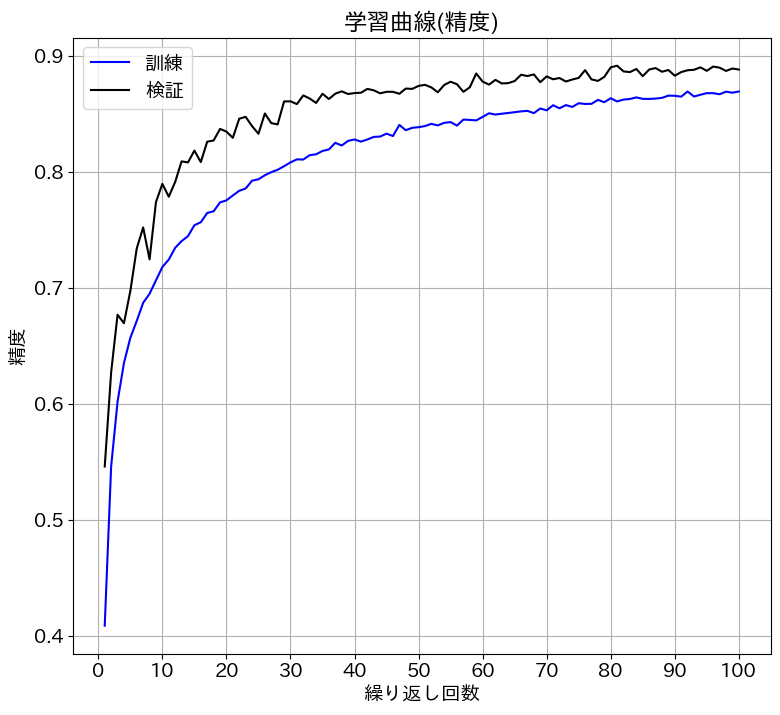

In [41]:
evaluate_history(history)

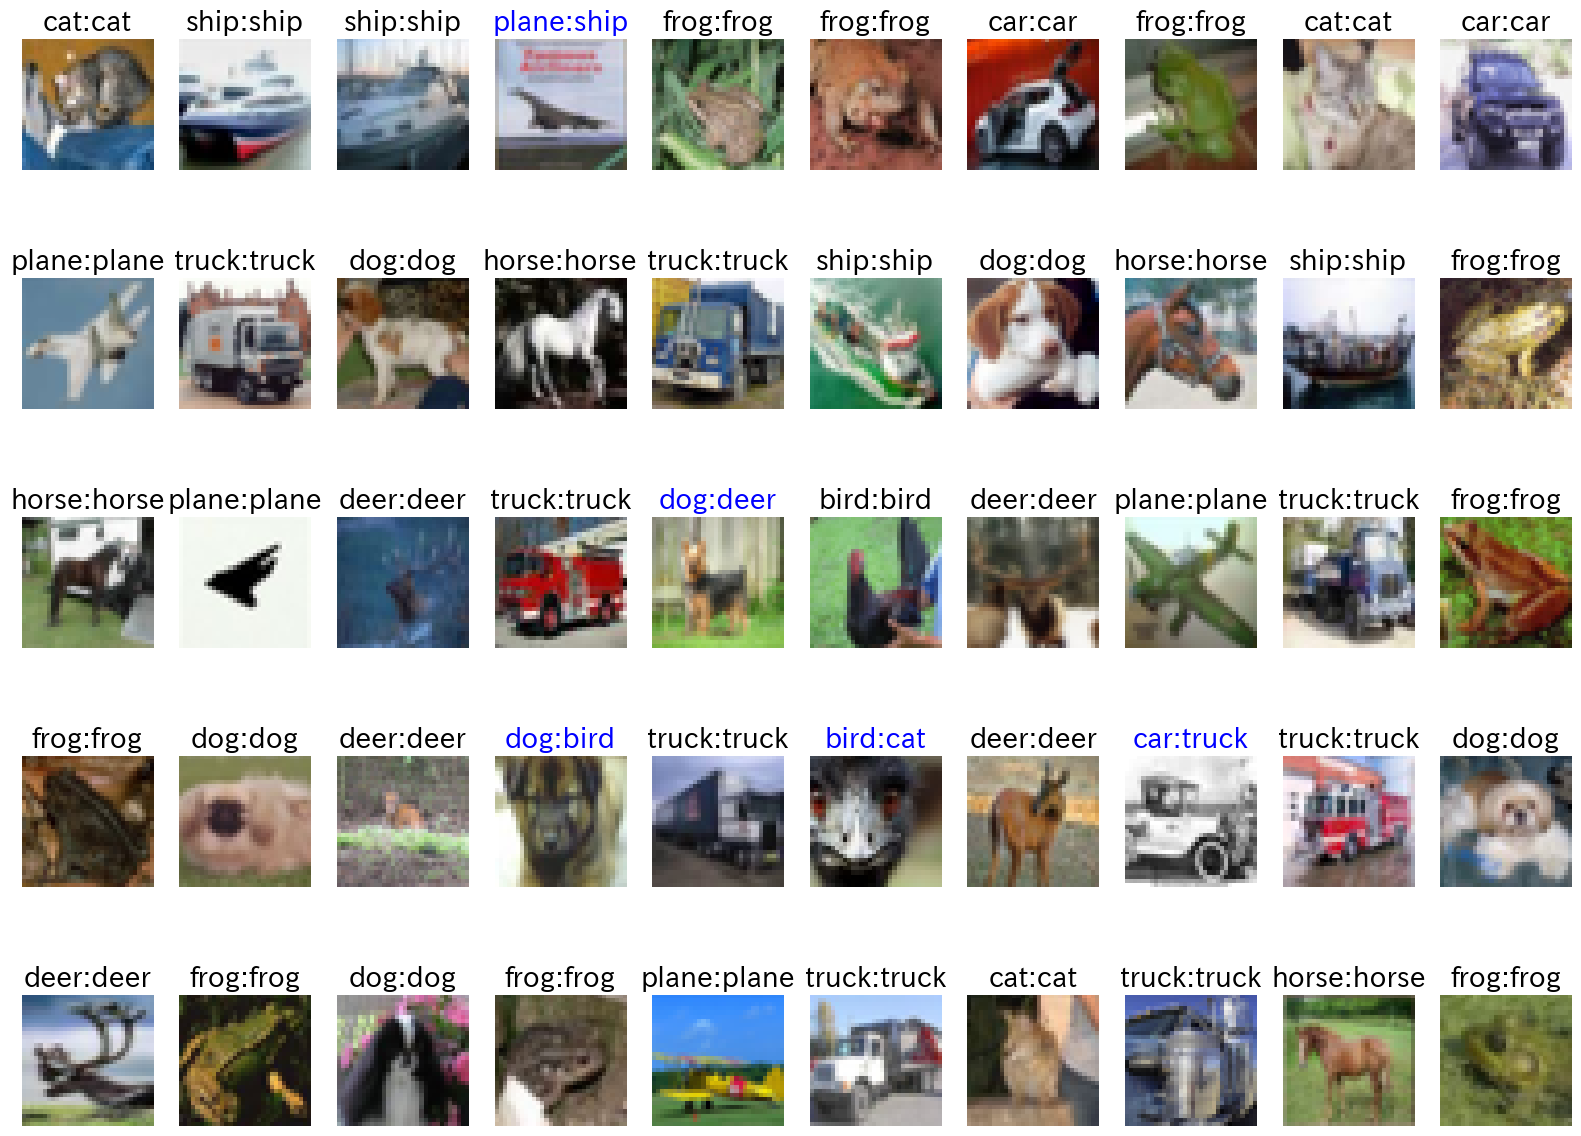

In [42]:
show_images_labels(test_loader, classes, net, device)

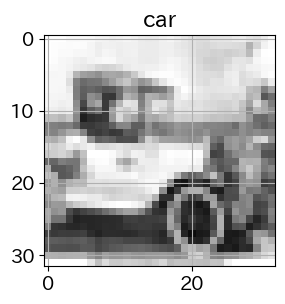

In [43]:
# 間違えた38番目のデータを抽出
for images, labels in test_loader:
    break
image = images[37]
label = labels[37]

# イメージを表示して確認
plt.figure(figsize=(3,3))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2
plt.title(classes[label])
plt.imshow(w3)
plt.show()

In [44]:
# 予測値を取得
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

# ラベル別の確率値を表示
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
values = np.frompyfunc(lambda x: f'{x:.04f}', 1, 1)(probs_np)
names = np.array(classes)
tbl = np.array([names, values]).T
print(tbl)

[['plane' '0.0000']
 ['car' '0.0677']
 ['bird' '0.0000']
 ['cat' '0.0000']
 ['deer' '0.0000']
 ['dog' '0.0000']
 ['frog' '0.0000']
 ['horse' '0.0000']
 ['ship' '0.0001']
 ['truck' '0.9323']]


## コラム　Batch Normalization利用上の注意点

### ダメなクラス定義の例

In [45]:
class CNN_v5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn1,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn2,
            self.relu,
            self.conv4,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn3,
            self.relu,
            self.conv6,
            self.bn3,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [46]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [47]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.50072 acc: 0.44756 val_loss: 2.28460, val_acc: 0.23550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.12691 acc: 0.59874 val_loss: 2.94008, val_acc: 0.12540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.98094 acc: 0.65392 val_loss: 2.41175, val_acc: 0.11480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.88894 acc: 0.69170 val_loss: 3.32396, val_acc: 0.10260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.82987 acc: 0.71500 val_loss: 3.29076, val_acc: 0.10180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.77607 acc: 0.73428 val_loss: 2.90097, val_acc: 0.13980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.73915 acc: 0.74674 val_loss: 3.67744, val_acc: 0.10110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.69704 acc: 0.76276 val_loss: 4.18566, val_acc: 0.10450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.66443 acc: 0.77428 val_loss: 2.52631, val_acc: 0.13290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.63544 acc: 0.78506 val_loss: 2.91836, val_acc: 0.10030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.59904 acc: 0.79832 val_loss: 3.78209, val_acc: 0.10300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.58242 acc: 0.80370 val_loss: 2.89884, val_acc: 0.10410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.55150 acc: 0.81302 val_loss: 3.19436, val_acc: 0.10020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53354 acc: 0.82006 val_loss: 3.65274, val_acc: 0.10060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.51982 acc: 0.82526 val_loss: 2.54065, val_acc: 0.11820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.50085 acc: 0.83320 val_loss: 3.32984, val_acc: 0.10140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.48344 acc: 0.83586 val_loss: 4.05243, val_acc: 0.10010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.47272 acc: 0.84000 val_loss: 3.00719, val_acc: 0.10010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.46107 acc: 0.84526 val_loss: 3.46039, val_acc: 0.10020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.44542 acc: 0.84978 val_loss: 3.47012, val_acc: 0.10010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.43328 acc: 0.85298 val_loss: 3.29644, val_acc: 0.10010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.42623 acc: 0.85714 val_loss: 3.03963, val_acc: 0.10080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.41310 acc: 0.86118 val_loss: 3.17480, val_acc: 0.10020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.40189 acc: 0.86522 val_loss: 3.20010, val_acc: 0.10140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.39439 acc: 0.86618 val_loss: 2.56175, val_acc: 0.12760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.38978 acc: 0.86822 val_loss: 3.07717, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.38085 acc: 0.87146 val_loss: 2.88850, val_acc: 0.10140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.37476 acc: 0.87522 val_loss: 3.23637, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.36394 acc: 0.87632 val_loss: 3.17928, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.36087 acc: 0.87844 val_loss: 3.65465, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.35063 acc: 0.88086 val_loss: 3.23039, val_acc: 0.10010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.34889 acc: 0.88134 val_loss: 3.52044, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.33892 acc: 0.88522 val_loss: 3.44598, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.33418 acc: 0.88658 val_loss: 3.31844, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.32886 acc: 0.88880 val_loss: 3.30520, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.32531 acc: 0.88944 val_loss: 3.13789, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.31460 acc: 0.89206 val_loss: 3.51807, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.30831 acc: 0.89688 val_loss: 4.06570, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.31099 acc: 0.89462 val_loss: 2.88697, val_acc: 0.10210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.30126 acc: 0.89840 val_loss: 3.02515, val_acc: 0.10110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.29205 acc: 0.90070 val_loss: 3.43237, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.29590 acc: 0.89764 val_loss: 3.09520, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.29555 acc: 0.90040 val_loss: 2.80074, val_acc: 0.10030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.28453 acc: 0.90308 val_loss: 2.76271, val_acc: 0.10270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.28438 acc: 0.90310 val_loss: 3.58939, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.27732 acc: 0.90610 val_loss: 3.27498, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.26819 acc: 0.90928 val_loss: 3.20292, val_acc: 0.10310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.26696 acc: 0.90956 val_loss: 3.32108, val_acc: 0.10570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.26580 acc: 0.90902 val_loss: 3.58190, val_acc: 0.11370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.26522 acc: 0.90936 val_loss: 4.65785, val_acc: 0.10020


In [ ]:
# 損失の計算グラフ可視化
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## コラム Batch Normlizationの処理内容

In [ ]:
# 入力用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 1, 10)
print(inputs)

In [ ]:
# 入力ミニバッチデータの統計量計算

i_mean = inputs.mean()
i_var = inputs.var(unbiased=True)
i_std = inputs.std(unbiased=False)
print(i_mean, i_std, i_var)

In [ ]:
# BN関数の定義

bn = nn.BatchNorm1d(1)
print(bn.running_mean)
print(bn.running_var)
print(bn.weight.data)
print(bn.bias.data)

In [ ]:
# BN関数の疑似呼び出し

bn.train()
print('===訓練フェーズ1===')
outputs1 = bn(inputs)
print(outputs1.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測フェーズ1===')
outputs2 = bn(inputs)
print(outputs2.data)
print(bn.running_mean)
print(bn.running_var)

bn.train()
print('===訓練フェーズ2===')
outputs3 = bn(inputs)
print(outputs3.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測フェーズ2===')
outputs4 = bn(inputs)
print(outputs4.data)
print(bn.running_mean)
print(bn.running_var)


In [ ]:
# 訓練フェーズの出力

xt = (inputs - i_mean)/i_std * bn.weight + bn.bias
print(xt.data)

print(outputs1.data)

In [ ]:
# 予測フェーズの出力

xp = (inputs-bn.running_mean)/torch.sqrt(bn.running_var)
print(xp.data)

print(outputs4.data)

In [ ]:
# running_meanとrunnung_varの計算式

# 初期値
mean0 = 0
var0 = 1
momentum = bn.momentum

# 移動平均計算1回目
mean1 = (1-momentum) * mean0 +  momentum * i_mean
var1 = (1-momentum) * var0 +  momentum * i_var
print(mean1, var1)

# 移動平均計算2回目
mean2 = (1-momentum) * mean1 +  momentum * i_mean
var2 = (1-momentum) * var1 +  momentum * i_var
print(mean2, var2)
